In [15]:
import sys
import os
import itertools
import numpy as np
import torch as tr
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context('talk')

import multiprocessing as mp
import concurrent

from utils import *

%load_ext autoreload
%reload_ext autoreload
%autoreload 2


In [16]:
# multiprocess fun for parallelizing simulations across seeds
def exp_mp(seed_exp,nseeds,gsvar=None):
  """ 
  first argument is seed_exp method
  seed_exp takes one dummy arguments
    placeholder for iterating over seeds
  seed_exp could also take second argument
    variable condition repeated over seeds 
    used for gridsearching
  """
  with concurrent.futures.ProcessPoolExecutor() as exe:
    data = exe.map(seed_exp, np.arange(nseeds), np.repeat(gsvar,nseeds))
  return np.array([i for i in data])
  

### main loop

In [42]:
agent_kw = {'gamma':0,'learnrate':0.0005}
agent = ActorCritic(**agent_kw)
tsteps = 3
task_kw = {'epoch_len':6,'trlen':3}
task = PWMTaskFR(**task_kw)

In [49]:
tr.(epoch_data['reward'])

TypeError: expected Tensor as element 0 in argument 0, but got numpy.ndarray

In [37]:
tr.cat(epoch_data['logpr_actions'])
rewards = tr.cat(epoch_data['reward'])
rewards

TypeError: expected Tensor as element 0 in argument 0, but got numpy.ndarray

In [44]:
neps=1
reward = -np.ones(neps)
loss = -np.ones([2,neps])
pism = -np.ones([3,neps])
L = []
for epoch in range(neps):
  epoch_data = run_epoch_FR(agent,task)
  print()
  print(epoch_data)
  L.append(epoch_data)
  loss[:,epoch] = agent.update(epoch_data)
  reward[epoch] = np.sum(epoch_data['reward'][-1])/task.ntrials
  pism[:,epoch] = epoch_data['pism'][-1].squeeze().detach().numpy()
  


{'state': [array([0., 0., 2.]), array([0., 0., 1.])], 'obs': [array([[1., 0.],
       [0., 0.],
       [0., 1.]]), array([[0., 1.],
       [0., 0.],
       [1., 0.]])], 'action': [tensor([[0],
        [0],
        [0]]), tensor([[1],
        [1],
        [1]])], 'reward': [array([0., 0., 0.]), array([ 0.,  0., 10.])], 'vhat': [tensor([[[0.0124]],

        [[0.0340]],

        [[0.0372]]], grad_fn=<AddBackward0>), tensor([[[0.0266]],

        [[0.0432]],

        [[0.0261]]], grad_fn=<AddBackward0>)], 'distr': [Categorical(probs: torch.Size([3, 1, 3]), logits: torch.Size([3, 1, 3])), Categorical(probs: torch.Size([3, 1, 3]), logits: torch.Size([3, 1, 3]))], 'ttype': [1, 1], 'logpr_actions': [tensor([[-1.1303],
        [-1.1315],
        [-1.1344]], grad_fn=<SqueezeBackward1>), tensor([[-1.1487],
        [-1.1475],
        [-1.1396]], grad_fn=<SqueezeBackward1>)], 'pism': [tensor([[[0.3229, 0.3123, 0.3648]],

        [[0.3225, 0.3153, 0.3622]],

        [[0.3216, 0.3228, 0.3556]]], grad

ValueError: operands could not be broadcast together with shapes (2,3) (2,) 

In [5]:
epoch_data

{'state': [0.0, 0.0, 2.0],
 'obs': [array([1., 0.]), array([0., 0.]), array([0., 1.])],
 'action': [tensor([0]), tensor([0]), tensor([2])],
 'reward': [0.0, 0.0, 1.0],
 'vhat': [tensor([[[-0.0034]],
  
          [[-0.0050]],
  
          [[ 1.0021]]], grad_fn=<AddBackward0>)],
 'distr': [Categorical(probs: torch.Size([3, 1, 3]), logits: torch.Size([3, 1, 3]))],
 'ttype': [1],
 'logpr_actions': [tensor([[-1.1921e-07],
          [-1.1921e-07],
          [-1.1921e-07]], grad_fn=<SqueezeBackward1>)],
 'pism': [tensor([[1.0000e+00, 8.1892e-08, 6.4917e-09]], grad_fn=<UnbindBackward>),
  tensor([[1.0000e+00, 5.2095e-13, 1.5397e-10]], grad_fn=<UnbindBackward>),
  tensor([[1.6664e-08, 6.7193e-08, 1.0000e+00]], grad_fn=<UnbindBackward>)]}

In [6]:
epoch_data['reward']

[0.0, 0.0, 1.0]

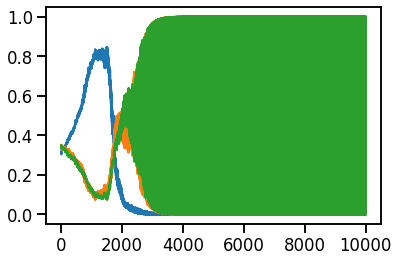

In [7]:
for p in pism:
  plt.plot(p)

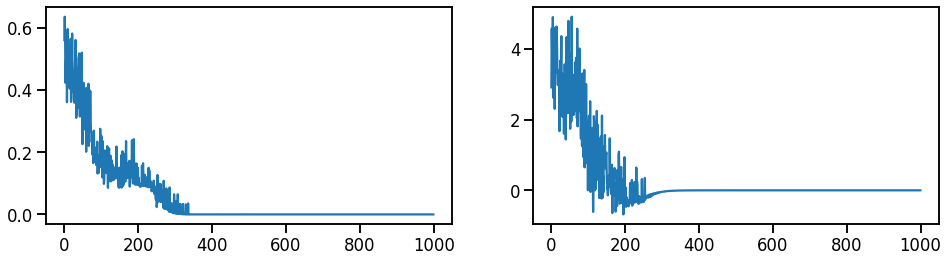

In [8]:
f,ax = plt.subplots(1,2,figsize=(16,4))
w = 10
for i in range(2):
  ax[i].plot(loss[i].reshape(-1,w).mean(1))

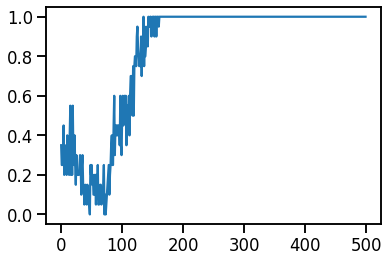

In [9]:
w=20
plt.plot(reward.reshape(-1,w).mean(1))

In [10]:
S,O = task.sample_trial(1)
print(S,O)


[0. 0. 1.] [[0. 1.]
 [0. 0.]
 [1. 0.]]


In [11]:
assert False

AssertionError: 

In [ ]:
def seed_exp(_seed,gsvar=None,neps=1000):  
  agent = ActorCritic()
  task_kw = {'trlen':3}
  task = PWMTaskFR(**task_kw)

  reward = -np.ones(neps)
  for epoch in range(neps):
    epoch_data = run_epoch_FR(agent,task)
    agent.update(epoch_data)
    reward[epoch] = np.sum(epoch_data['reward'])/task.ntrials
  return reward

In [ ]:
seed_exp(_seed,gsvar)

In [ ]:
nseeds,neps = 15,15000
muL = [[0,1],[-1,0]]
sigmaL = [0.5,1,2]
mu = [-1,1]
sigma = 2

dataL = []
for gs_var in sigmaL:
  print(gs_var)
  sigma = gs_var
  
  # run over multiple seeds
  data = exp_mp(seed_exp,nseeds)
  dataL.append(data)
results = np.array(dataL)